In [1]:
# Importing the necessary libraries for the project. 
import pandas as pd 
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
import matplotlib.dates as mdates
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from math import sqrt
# ParameterSampler for randomized hyperparameter sampling, optimizing model parameters in cross-validation.
from sklearn.model_selection import ParameterSampler
# pmdarima's auto_arima for automated selection of the best ARIMA parameters based on AIC/BIC scores.
from pmdarima import auto_arima
# Mean Squared Error and Mean Absolute Error metrics from sklearn for evaluating model accuracy.
from sklearn.metrics import mean_squared_error, mean_absolute_error
# TimeSeriesSplit for cross-validation with time series data to preserve the temporal ordering of data.
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch

import warnings # filter warnings
warnings.filterwarnings('ignore')

# Testing baseline SARIMA with exogenous variables (SARIMAX). 

- **Evaluation of final baseline model will be performed between the comparison of best model with and withou exogenous variables**

In [3]:
# Importing the dataset after the Log Returns transformation.
df1 = pd.read_csv('df1.csv', index_col=0, parse_dates=True)

# Along with the importation, the code will set the date as the index, value of 0 because is the first column.
## Setting parse_dates=true to ensure the dates are in datetime, making more appropriate for ML models.

In [4]:
df1.head()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
Date,,,,,,
2004-04-01,0.012635,0.031461,-0.023861,0.003674,0.000735,117.596902
2004-04-08,-0.010896,0.012635,-0.000125,0.000981,-0.001424,117.741650
2004-04-15,-0.003623,-0.010896,-0.029274,0.007394,-0.000325,0.776477
2004-04-22,-0.001496,-0.003623,0.031461,-0.000845,-0.000305,0.623353
2004-04-29,-0.000784,-0.001496,0.012635,-0.004200,-0.002649,0.647610


In [5]:
df1.describe()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
count,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000
mean,0.001575,0.001608,0.001508,0.001578,0.001516,7.731465
std,0.020723,0.020744,0.020750,0.009796,0.005364,23.505939
min,-0.069935,-0.069935,-0.069935,-0.051352,-0.026288,0.154122
25%,-0.007633,-0.007633,-0.007858,-0.003032,-0.001013,1.538535
50%,0.003635,0.003666,0.003626,0.002937,0.002346,2.585030
75%,0.013568,0.013643,0.013514,0.007596,0.004979,6.157669
max,0.051947,0.051947,0.051947,0.031089,0.019145,338.128664


In [6]:
# Define the selected exogenous variables
ex1 = df1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']]

In [7]:
# Define the split index for the train-test split (85% train, 15% test)
split_index = int(0.90 * len(df1))

# Target variable split
train = df1['Close'][:split_index]
test = df1['Close'][split_index:]

# Exogenous variables split
exo_train = ex1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']][:split_index]
exo_test = ex1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']][split_index:]

- SARIMAX model being tested by random parameters with yearly seasonality (12 weeks). 

The workflow of SARIMAX will follow the same path as the SARIMA: 
- Random parameter: Random values, starting point for hyper-parameter tunning.

- Hyper-parameter tunning: Auto-arima and Random Search. The first will search through combinations that has the lower AIC value and the second will be performed along with cross validation techniques searching for the best RMSE.

- Cross-Validation: Time-Series and Fixed Rolling Window.

- Residuals: The analysis will be performed on the best model.   

**The evaluation of results and performance of each model will be at the end, when all models have being applied along with cross-validation techniques**. 






Performing auto-arima to find optimal parameters using two different frequencies monthly and quaterly. 

                                        SARIMAX Results                                        
Dep. Variable:                                   Close   No. Observations:                  927
Model:             SARIMAX(2, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                2631.030
Date:                                 Mon, 18 Nov 2024   AIC                          -5238.060
Time:                                         15:28:04   BIC                          -5180.076
Sample:                                     04-01-2004   HQIC                         -5215.941
                                          - 12-30-2021                                         
Covariance Type:                                   opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.3987      0.078     17.888      0.000  

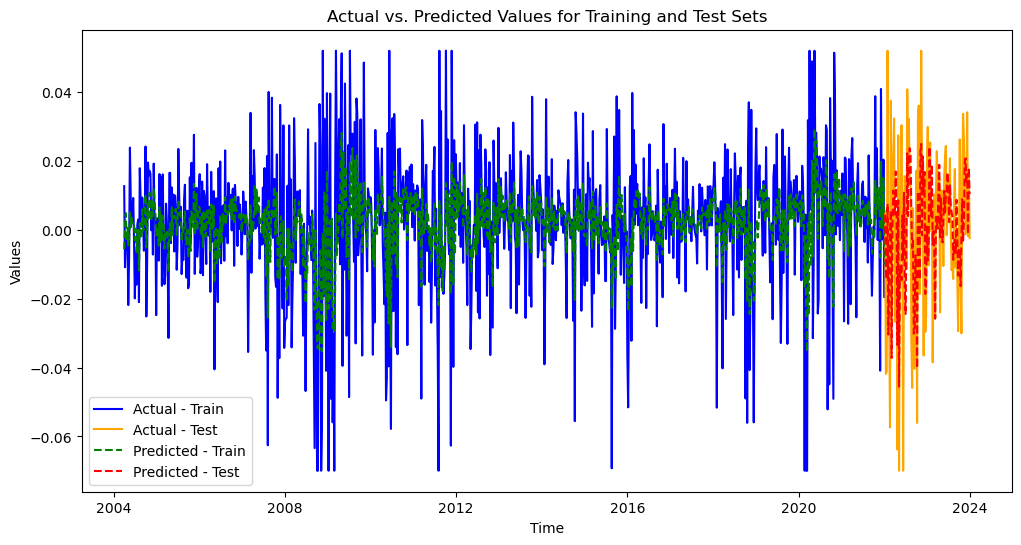

In [10]:
# Define SARIMAX model 
sarimax_model = SARIMAX(train, order=(2, 0, 1), seasonal_order=(1, 0, 2, 12), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

### AUTO-ARIMA

- 52 Weeks Frequency (One Year)

In [12]:
# Sets random seed for reproducibility
np.random.seed(42)

# Perform auto_arima with specified seed and exogenous variables
auto_model = auto_arima(train, 
                        exogenous=exo_train, 
                        seasonal=True,
                        m=52,  # Set seasonality period, e.g., 12 for weekly data with quaterly seasonality
                        trace=True,  # Prints the model selection process
                        error_action='ignore',  # Ignore models that fail to fit
                        suppress_warnings=True,  # Suppress warnings
                        stepwise=True,  # Stepwise approach for faster search
                        random=True,  # Random search
                        random_state=42,  # Seed for reproducibility
                        n_fits=50)  # Number of models to try

# Print the best model found
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=-4604.419, Time=150.72 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=-4610.277, Time=0.38 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=-4611.821, Time=69.94 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=-4612.020, Time=38.03 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=-4605.606, Time=0.70 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=-4612.115, Time=1.00 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=-4611.923, Time=26.52 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=-4609.591, Time=46.65 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=-4610.300, Time=0.36 sec
 ARIMA(0,0,2)(0,0,0)[52] intercept   : AIC=-4610.339, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=-4611.979, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=-4608.263, Time=0.55 sec
 ARIMA(0,0,1)(0,0,0)[52]             : AIC=-4606.517, Time=0.34 sec

Best model:  ARIMA(0,0,1)(0,0,0)[52] intercept
Total fit time: 335

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  927
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 52)   Log Likelihood                2520.841
Date:                            Mon, 18 Nov 2024   AIC                          -5025.682
Time:                                    15:35:42   BIC                          -4987.027
Sample:                                04-01-2004   HQIC                         -5010.937
                                     - 12-30-2021                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.3987      0.081     17.312      0.000       1.240       1.557
rolling_mean_12w 

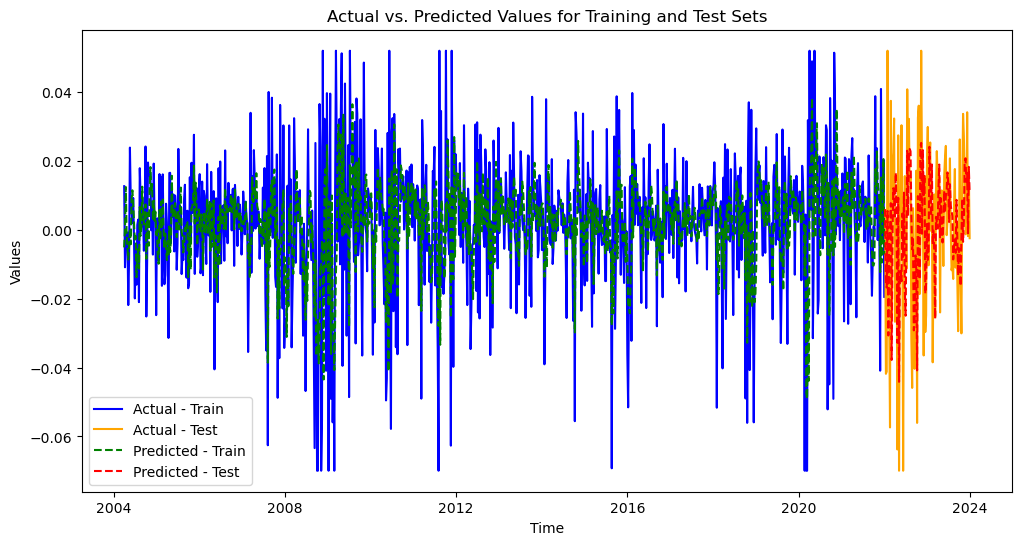

In [13]:
# Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 0, 1, 52), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [14]:
# Sets random seed for reproducibility.
np.random.seed(42)

# Perform auto_arima with specified seed and exogenous variables.
auto_model = auto_arima(train, 
                        exogenous=exo_train, 
                        seasonal=True,
                        m=26,  # Set seasonality period, e.g., 52 for weekly data with yearly seasonality.
                        trace=True,  # Prints the model selection process.
                        error_action='ignore',  # Ignore models that fail to fit.
                        suppress_warnings=True,  # Suppress warnings.
                        stepwise=True,  # Stepwise approach for faster search.
                        random=True,  # Random search.
                        random_state=42,  # Seed for reproducibility.
                        n_fits=50)  # Number of models to try.

# Print the best model found.
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[26] intercept   : AIC=-4603.794, Time=22.31 sec
 ARIMA(0,0,0)(0,0,0)[26] intercept   : AIC=-4610.277, Time=0.32 sec
 ARIMA(1,0,0)(1,0,0)[26] intercept   : AIC=-4610.040, Time=11.65 sec
 ARIMA(0,0,1)(0,0,1)[26] intercept   : AIC=-4610.184, Time=3.79 sec
 ARIMA(0,0,0)(0,0,0)[26]             : AIC=-4605.606, Time=0.22 sec
 ARIMA(0,0,0)(1,0,0)[26] intercept   : AIC=-4608.254, Time=2.83 sec
 ARIMA(0,0,0)(0,0,1)[26] intercept   : AIC=-4608.132, Time=1.80 sec
 ARIMA(0,0,0)(1,0,1)[26] intercept   : AIC=-4606.494, Time=4.47 sec
 ARIMA(1,0,0)(0,0,0)[26] intercept   : AIC=-4611.979, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[26] intercept   : AIC=-4610.046, Time=3.12 sec
 ARIMA(1,0,0)(1,0,1)[26] intercept   : AIC=-4608.289, Time=3.46 sec
 ARIMA(2,0,0)(0,0,0)[26] intercept   : AIC=-4610.365, Time=0.61 sec
 ARIMA(1,0,1)(0,0,0)[26] intercept   : AIC=-4610.300, Time=0.36 sec
 ARIMA(0,0,1)(0,0,0)[26] intercept   : AIC=-4612.115, Time=0.52 sec
 AR

- 26 Weeks Frequency (Half-Year)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  927
Model:               SARIMAX(0, 0, 1)   Log Likelihood                2520.329
Date:                Mon, 18 Nov 2024   AIC                          -5026.659
Time:                        15:36:47   BIC                          -4992.835
Sample:                    04-01-2004   HQIC                         -5013.756
                         - 12-30-2021                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.3987      0.080     17.419      0.000       1.241       1.556
rolling_mean_12w    -0.0471      0.102     -0.460      0.645      -0.248       0.153
volatility_4w     1.224e-05 

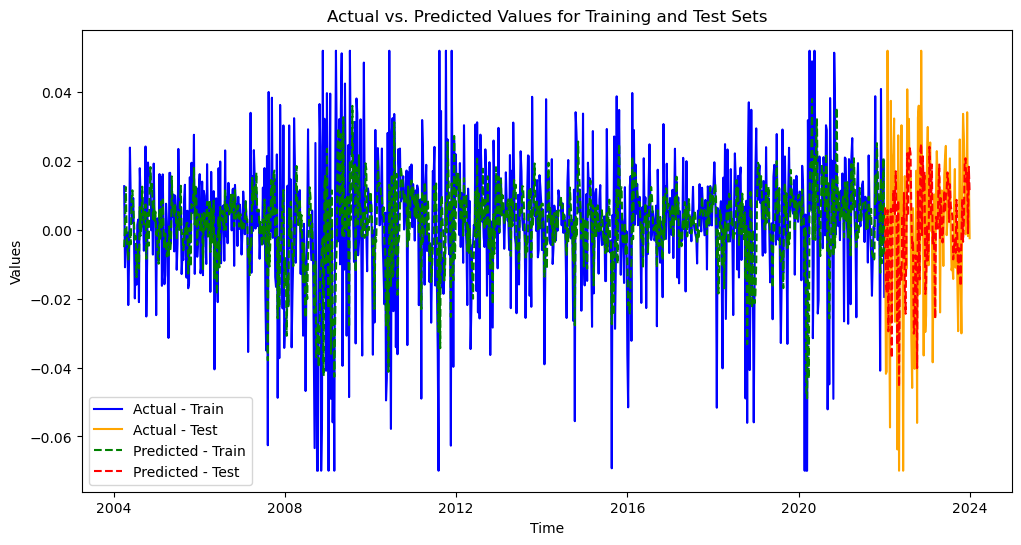

In [16]:
# Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 0, 0, 26), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

- 12 Weeks (Quaterly)

In [18]:
# Sets random seed for reproducibility
np.random.seed(42)

# Perform auto_arima with specified seed and exogenous variables
auto_model = auto_arima(train, 
                        exogenous=exo_train, 
                        seasonal=True,
                        m=12,  # Set seasonality period, e.g., 12 for weekly data with quaterly seasonality
                        trace=True,  # Prints the model selection process
                        error_action='ignore',  # Ignore models that fail to fit
                        suppress_warnings=True,  # Suppress warnings
                        stepwise=True,  # Stepwise approach for faster search
                        random=True,  # Random search
                        random_state=42,  # Seed for reproducibility
                        n_fits=50)  # Number of models to try

# Print the best model found
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-4605.066, Time=7.14 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-4610.277, Time=0.87 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-4612.734, Time=2.58 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-4612.918, Time=3.31 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-4605.606, Time=0.53 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-4612.115, Time=1.39 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-4610.886, Time=3.16 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-4610.992, Time=5.32 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-4612.855, Time=2.65 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-4608.994, Time=9.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-4611.112, Time=1.09 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-4611.019, Time=1.31 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=-4611.084, Time=3.45 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-4612.789, Time=1.54 sec
 ARIM

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  927
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood                2521.775
Date:                            Mon, 18 Nov 2024   AIC                          -5027.551
Time:                                    15:37:44   BIC                          -4988.895
Sample:                                04-01-2004   HQIC                         -5012.805
                                     - 12-30-2021                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.3987      0.081     17.340      0.000       1.241       1.557
rolling_mean_12w 

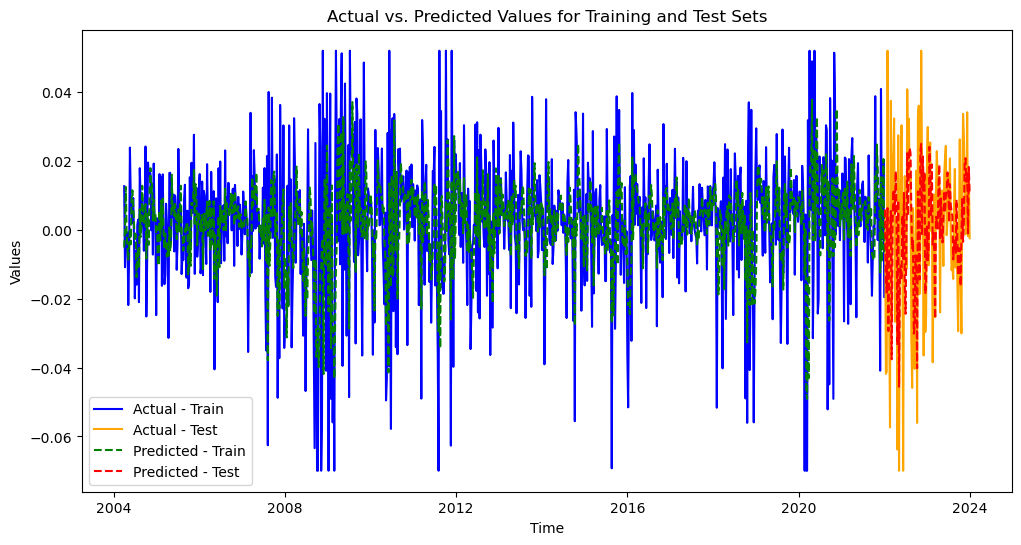

In [19]:
# Define SARIMAX model 
sarimax_model = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 0, 1, 12), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

- With different types of hyper-parameter tunning, the random search will be selected to to find the optimal parameters (30 different). The selection is due to the trade-off between range of values and computational resources (takes too long to run). In addition, a random state will be added to ensure reproducibility (same results).
- Grid Search was attempted but it was extremely computational expensive (especially for m=52).

Instead of applying the random search on a simple train and test set, the approach will be performed along with cross validation, providing a more reliable RMSE across differend folds. Despite being more computational expensive it will validade the model at the same time. 

<b> Six Months Frequency (m=26) </b>

- Random Search + TSCV

In [21]:
# Define the train-test split indices for time-series cross-validation.
n_splits = 4
test_window = 50  # Number of rows for each test set.
initial_train_window = len(train) - n_splits * test_window

# Parameter grid and random sampling as defined in your prompt.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [26]
}

# Number of combinations to try.
n_iter_search = 30  # Number of random parameter combinations.
# Creates a list of the parameters tested and random_state is being called to reproduce same combinations. 
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Function to evaluate SARIMA with cross-validation.
def evaluate_sarima_cv_rmse(params): # Defining params (p,q,d) and seasonal (p,q,d,m).
    """
    Performs rolling cross-validation on SARIMA model with specified parameters and returns average RMSE.
    """
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rmse_scores = []  # Store RMSE for each fold.
    
    for i in range(n_splits):
        # Define the train and test indices for this fold.
        train_end = initial_train_window + i * test_window
        test_end = train_end + test_window
        
        y_train, y_test = train[:train_end], train[train_end:test_end]
        X_train, X_test = exo_train[:train_end], exo_train[train_end:test_end]
        
        try:
            # Fit SARIMA model on the current training set
            model = sm.tsa.statespace.SARIMAX(y_train,
                                              order=(p, d, q),
                                              seasonal_order=(P, D, Q, m),
                                              exog=X_train,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            result = model.fit(disp=False)

            # Forecast on the current test set (one-step ahead only)
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE for this fold.
            rmse = mean_squared_error(y_test, forecast, squared=False)
            rmse_scores.append(rmse)
        except Exception as e:
            print(f"Failed to fit model for parameters {params} on fold {i+1}: {e}")
            return np.inf  # Return large RMSE if fitting fails for this parameter set.
    
    # Calculate the average RMSE across all folds.
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Initialize variables to store the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

# Perform random search with cross-validation.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}") # Prints the parameters tested.
    
    # Evaluate SARIMA model with cross-validation.
    rmse = evaluate_sarima_cv_rmse(params)
    
    # Track the best performing parameters and RMSE.
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

    print(f"Average RMSE across folds: {rmse}") # Prints the RMSE avg of each combinations.

# Output the best parameters and the best RMSE score
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average RMSE across folds: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 26, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}
Average RMSE across folds: 0.017225637419135846
Testing SARIMA parameters: {'q': 2, 'p': 1, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}
Average RMSE across folds: 0.02778236757272249
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 26, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}
Average RMSE across folds: 0.028525418836509983
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}
Average RMSE across folds: 0.029968640441432614
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average RMSE across folds: 0.03295907081417023
Testing SARIMA parameters: {'q': 0, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average RMSE across folds: 0.03478943999947614
Testing SARIMA parameters: {'q': 3, 'p': 0, 'm': 26, 'd': 0, 'Q': 2, 'P': 2, 'D': 0}
Average RMSE across folds: 0.017259909947523546
Testing SARIMA parameters: {'q': 1, 'p': 3, 'm': 26, 'd': 1, 'Q': 0, 'P'


KeyboardInterrupt



In [ ]:
# Time-Series CV. 
## Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(0, 0, 3), seasonal_order=(2, 0, 2, 26), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

- The present parameter presents the lower AIC at thi point (-5117.63).
- The model summary shows that the feature rolling_mean_4w has great impact, meanwhile lag_1 has a negative effect.  

In [ ]:
# Define a 4 week (one month) horizon for evaluation metrics.
horizon = 4

# Calculate RMSE over the 4 week (one month) horizon.
fours_weeks_rmse = np.sqrt(mean_squared_error(test[horizon:], test_predictions[:-horizon]))

# Calculate MAE over 4 week (one month) horizon.
fours_weeks_mae = mean_absolute_error(test[horizon:], test_predictions[:-horizon])

# Calculate 4 week (one month) Directional Accuracy.
direction_accuracy = np.mean(
    np.sign(test_predictions[:-horizon] - test_predictions[horizon:]) == 
    np.sign(test[:-horizon] - test[horizon:])
)

# Print evaluation metrics.
print("4 week (one month) Horizon RMSE:", fours_weeks_rmse)
print("4 week (one month) Horizon MAE:", fours_weeks_mae)
print(f"4 week (one month) Horizon Directional Accuracy: {direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on test set.
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Test Set (5-Day Horizon)")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

- Random Search + Fixed Rolling window CV

In [ ]:
# Define parameter grid for SARIMA.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [26]  # Seasonal period.
}

# Number of random parameter combinations to try.
n_iter_search = 30  
# Creates a list of the parameters tested and random_state is being called to reproduce same combinations. 
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Initialize to track the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

window_size = 300  # Fixed training window size.
test_size = 50  # Fixed test window size.

# Loop over each parameter combination in the random sample.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rolling_rmses = []  # Store RMSE for each rolling window iteration.
    
    # Perform rolling window cross-validation.
    for i in range(0, len(train) - window_size - test_size, test_size):
        y_train = train[i:i + window_size]
        y_test = train[i + window_size:i + window_size + test_size]
        X_train = exo_train[i:i + window_size]
        X_test = exo_train[i + window_size:i + window_size + test_size]

        try:
            # Fit SARIMA model on the current training set with sampled parameters.
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                exog=X_train,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)

            # Forecast on the current test set (only one-step ahead).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE for this fold.
            rmse = np.sqrt(mean_squared_error(y_test, forecast))
            rolling_rmses.append(rmse)
        except Exception as e:
            print(f"Failed to fit model on iteration {i} with parameters {params}: {e}")
            rolling_rmses.append(np.inf)  # Assign high error if fitting fails.
    
    # Calculate the average RMSE across all rolling windows for the current parameter set
    avg_rolling_rmse = np.mean(rolling_rmses)
    print(f"Average Rolling Window RMSE for parameters {params}: {avg_rolling_rmse}")

    # Update best parameters if the current RMSE is lower
    if avg_rolling_rmse < best_rmse:
        best_rmse = avg_rolling_rmse
        best_params = params

# Output the best parameters and the best RMSE score
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average Rolling Window RMSE: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

In [ ]:
# Fixed Rolling window CV. 
## Define SARIMAX model. 
sarimax_model = SARIMAX(train, order=(1, 0, 3), seasonal_order=(1, 0, 2, 26), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [ ]:
# Define a 4 week (one month) horizon for evaluation metrics.
horizon = 4

# Calculate RMSE over the 4 week (one month) horizon.
fours_weeks_rmse = np.sqrt(mean_squared_error(test[horizon:], test_predictions[:-horizon]))

# Calculate MAE over 4 week (one month) horizon.
fours_weeks_mae = mean_absolute_error(test[horizon:], test_predictions[:-horizon])

# Calculate 4 week (one month) Directional Accuracy.
direction_accuracy = np.mean(
    np.sign(test_predictions[:-horizon] - test_predictions[horizon:]) == 
    np.sign(test[:-horizon] - test[horizon:])
)

# Print evaluation metrics.
print("4 week (one month) Horizon RMSE:", fours_weeks_rmse)
print("4 week (one month) Horizon MAE:", fours_weeks_mae)
print(f"4 week (one month) Horizon Directional Accuracy: {direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on test set.
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Test Set (5-Day Horizon)")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

<b> Quaterly frequency (m=12) </b>

- Random Search + TSCV

In [ ]:
# Define the train-test split indices for time-series cross-validation.
n_splits = 4
test_window = 50  # Number of rows for each test set.
initial_train_window = len(train) - n_splits * test_window

# Parameter grid and random sampling as defined in your prompt.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [12]
}

n_iter_search = 30  # Number of random parameter combinations.
# Creates a list of the parameters tested and random_state is being called to reproduce same combinations.
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Updated function to evaluate SARIMA with cross-validation
def evaluate_sarima_cv_rmse(params): # Defining params (p,q,d) and seasonal (p,q,d,m).
    """
    Performs rolling cross-validation on SARIMA model with specified parameters and returns average RMSE.
    """
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rmse_scores = []  # Store RMSE for each fold.
    
    for i in range(n_splits):
        # Define the train and test indices for this fold.
        train_end = initial_train_window + i * test_window
        test_end = train_end + test_window
        
        y_train, y_test = train[:train_end], train[train_end:test_end]
        X_train, X_test = exo_train[:train_end], exo_train[train_end:test_end]
        
        try:
            # Fit SARIMA model on the current training set.
            model = sm.tsa.statespace.SARIMAX(y_train,
                                              order=(p, d, q),
                                              seasonal_order=(P, D, Q, m),
                                              exog=X_train,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            result = model.fit(disp=False)

            # Forecast on the current test set (one-step ahead only).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE for this fold.
            rmse = mean_squared_error(y_test, forecast, squared=False)
            rmse_scores.append(rmse)
        except Exception as e:
            print(f"Failed to fit model for parameters {params} on fold {i+1}: {e}")
            return np.inf  # Return large RMSE if fitting fails for this parameter set.
    
    # Calculate the average RMSE across all folds.
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Initialize variables to store the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

# Perform random search with cross-validation.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}") # Prints the parameters tested.
    
    # Evaluate SARIMA model with cross-validation.
    rmse = evaluate_sarima_cv_rmse(params)
    
    # Track the best performing parameters and RMSE.
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

    print(f"Average RMSE across folds: {rmse}") # Prints the RMSE avg of each combinations.

# Output the best parameters and the best RMSE score.
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average RMSE across folds: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

In [ ]:
# Time-Series CV.
## Define SARIMAX model. 
sarimax_model = SARIMAX(train, order=(1, 0, 3), seasonal_order=(1, 0, 2, 12), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [ ]:
# Define a 4 week (one month) horizon for evaluation metrics.
horizon = 4

# Calculate RMSE over the 4 week (one month) horizon.
fours_weeks_rmse = np.sqrt(mean_squared_error(test[horizon:], test_predictions[:-horizon]))

# Calculate MAE over 4 week (one month) horizon.
fours_weeks_mae = mean_absolute_error(test[horizon:], test_predictions[:-horizon])

# Calculate 4 week (one month) Directional Accuracy.
direction_accuracy = np.mean(
    np.sign(test_predictions[:-horizon] - test_predictions[horizon:]) == 
    np.sign(test[:-horizon] - test[horizon:])
)

# Print evaluation metrics.
print("4 week (one month) Horizon RMSE:", fours_weeks_rmse)
print("4 week (one month) Horizon MAE:", fours_weeks_mae)
print(f"4 week (one month) Horizon Directional Accuracy: {direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on test set.
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Test Set (5-Day Horizon)")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [ ]:
# Define parameter grid for SARIMA.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [12]  # Seasonal period.
}

# Number of random parameter combinations to try.
n_iter_search = 30  
# Creates a list of the parameters tested and random_state is being called to reproduce same combinations. 
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Initialize to track the best parameters and lowest average RMSE
best_rmse = np.inf
best_params = None

# Fixed Rolling Window Cross-Validation Configuration
window_size = 300  # Training window size to align with initial TSCV window.
test_size = 50     # Test window size to match TSCV.

# Loop over each parameter combination in the random sample.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rolling_rmses = []  # Store RMSE for each rolling window iteration.
    
    # Perform rolling window cross-validation.
    for i in range(0, len(train) - window_size - test_size, test_size):
        y_train = train[i:i + window_size]
        y_test = train[i + window_size:i + window_size + test_size]
        X_train = exo_train[i:i + window_size]
        X_test = exo_train[i + window_size:i + window_size + test_size]

        try:
            # Fit SARIMA model on the current training set with sampled parameters.
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                exog=X_train,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)

            # Forecast on the current test set (only one-step ahead).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE for this fold.
            rmse = np.sqrt(mean_squared_error(y_test, forecast))
            rolling_rmses.append(rmse)
        except Exception as e:
            print(f"Failed to fit model on iteration {i} with parameters {params}: {e}")
            rolling_rmses.append(np.inf)  # Assign high error if fitting fails.
    
    # Calculate the average RMSE across all rolling windows for the current parameter set.
    avg_rolling_rmse = np.mean(rolling_rmses)
    print(f"Average Rolling Window RMSE for parameters {params}: {avg_rolling_rmse}")

    # Update best parameters if the current RMSE is lower.
    if avg_rolling_rmse < best_rmse:
        best_rmse = avg_rolling_rmse
        best_params = params

# Output the best parameters and the best RMSE score.
print(f"Best parameters: {best_params}")  # Returns the best combinations among the 30 attempts.
print(f"Best average Rolling Window RMSE: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

In [ ]:
# Fixed Rolling window CV. 
## Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(1, 0, 3), seasonal_order=(1, 0, 2, 12), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [ ]:
# Define a 4 week (one month) horizon for evaluation metrics.
horizon = 4

# Calculate RMSE over the 4 week (one month) horizon.
fours_weeks_rmse = np.sqrt(mean_squared_error(test[horizon:], test_predictions[:-horizon]))

# Calculate MAE over 4 week (one month) horizon.
fours_weeks_mae = mean_absolute_error(test[horizon:], test_predictions[:-horizon])

# Calculate MAPE over the 4 week (one month) horizon.
fours_weeks_mape = np.mean(np.abs((test[horizon:] - test_predictions[:-horizon]) / test[horizon:])) * 100

# Calculate 5-day Directional Accuracy.
direction_accuracy = np.mean(
    np.sign(test_predictions[:-horizon] - test_predictions[horizon:]) == 
    np.sign(test[:-horizon] - test[horizon:])
)

# Print evaluation metrics.
print("4 week (one month) Horizon RMSE:", fours_weeks_rmse)
print("4 week (one month) Horizon MAE:", fours_weeks_mae)
print("4 week (one month) Horizon MAPE:", fours_weeks_mape)
print(f"5-Day Horizon Directional Accuracy: {direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on test set.
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Test Set 4 week (one month)")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

m=52

- Random Search + Fixed Rolling window CV

In [ ]:
# Define parameter grid for SARIMA.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [52]  # Seasonal period.
}

# Number of random parameter combinations to try.
n_iter_search = 30  
# Creates a list of the parameters tested and random_state is being called to reproduce same combinations. 
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Initialize to track the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

window_size = 300  # Fixed training window size.
test_size = 50  # Fixed test window size.

# Loop over each parameter combination in the random sample.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rolling_rmses = []  # Store RMSE for each rolling window iteration.
    
    # Perform rolling window cross-validation.
    for i in range(0, len(train) - window_size - test_size, test_size):
        y_train = train[i:i + window_size]
        y_test = train[i + window_size:i + window_size + test_size]
        X_train = exo_train[i:i + window_size]
        X_test = exo_train[i + window_size:i + window_size + test_size]

        try:
            # Fit SARIMA model on the current training set with sampled parameters.
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                exog=X_train,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)

            # Forecast on the current test set (only one-step ahead).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE for this fold.
            rmse = np.sqrt(mean_squared_error(y_test, forecast))
            rolling_rmses.append(rmse)
        except Exception as e:
            print(f"Failed to fit model on iteration {i} with parameters {params}: {e}")
            rolling_rmses.append(np.inf)  # Assign high error if fitting fails.
    
    # Calculate the average RMSE across all rolling windows for the current parameter set
    avg_rolling_rmse = np.mean(rolling_rmses)
    print(f"Average Rolling Window RMSE for parameters {params}: {avg_rolling_rmse}")

    # Update best parameters if the current RMSE is lower
    if avg_rolling_rmse < best_rmse:
        best_rmse = avg_rolling_rmse
        best_params = params

# Output the best parameters and the best RMSE score
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average Rolling Window RMSE: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

- Random Search + TSCV

In [ ]:
# Define the train-test split indices for time-series cross-validation.
n_splits = 4
test_window = 50  # Number of rows for each test set.
initial_train_window = len(train) - n_splits * test_window

# Parameter grid and random sampling as defined in your prompt.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [52]
}

n_iter_search = 30  # Number of random parameter combinations.
# Creates a list of the parameters tested and random_state is being called to reproduce same combinations.
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Updated function to evaluate SARIMA with cross-validation
def evaluate_sarima_cv_rmse(params): # Defining params (p,q,d) and seasonal (p,q,d,m).
    """
    Performs rolling cross-validation on SARIMA model with specified parameters and returns average RMSE.
    """
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rmse_scores = []  # Store RMSE for each fold.
    
    for i in range(n_splits):
        # Define the train and test indices for this fold.
        train_end = initial_train_window + i * test_window
        test_end = train_end + test_window
        
        y_train, y_test = train[:train_end], train[train_end:test_end]
        X_train, X_test = exo_train[:train_end], exo_train[train_end:test_end]
        
        try:
            # Fit SARIMA model on the current training set.
            model = sm.tsa.statespace.SARIMAX(y_train,
                                              order=(p, d, q),
                                              seasonal_order=(P, D, Q, m),
                                              exog=X_train,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            result = model.fit(disp=False)

            # Forecast on the current test set (one-step ahead only).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE for this fold.
            rmse = mean_squared_error(y_test, forecast, squared=False)
            rmse_scores.append(rmse)
        except Exception as e:
            print(f"Failed to fit model for parameters {params} on fold {i+1}: {e}")
            return np.inf  # Return large RMSE if fitting fails for this parameter set.
    
    # Calculate the average RMSE across all folds.
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Initialize variables to store the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

# Perform random search with cross-validation.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}") # Prints the parameters tested.
    
    # Evaluate SARIMA model with cross-validation.
    rmse = evaluate_sarima_cv_rmse(params)
    
    # Track the best performing parameters and RMSE.
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

    print(f"Average RMSE across folds: {rmse}") # Prints the RMSE avg of each combinations.

# Output the best parameters and the best RMSE score.
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average RMSE across folds: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

In [ ]:
# Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(1, 0, 3), seasonal_order=(1, 0, 2, 52), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

| Model                              | AIC        | Training RMSE | Test RMSE | Training MAE | Test MAE | Directional Accuracy (Train) | Directional Accuracy (Test) |
|------------------------------------|------------|---------------|-----------|--------------|----------|------------------------------|-----------------------------|
| (1, 0, 3)x(1, 0, [1, 2], 12)       | -5117.628  | 0.0128       | 0.0196    | 0.0094       | 0.0153   | 99.77%                       | 98.71%                      |
| (0, 0, 1)                          | -5003.852  | 0.0138       | 0.0216    | 0.0100       | 0.0170   | 99.77%                       | 98.71%                      |
| (0, 0, 1)x(0, 0, 1, 12)            | -4731.579  | 0.0161       | 0.0189    | 0.0118       | 0.0148   | 99.77%                       | 98.71%                      |
| (1, 0, 3)x(1, 0, [1, 2], 4)        | -5017.528  | 0.0136       | 0.0189    | 0.0098       | 0.0148   | 99.77%                       | 98.71%                      |
| (0, 0, 3)x(2, 0, [1, 2], 4)        | -5014.996  | 0.0136       | 0.0189    | 0.0099       | 0.0148   | 99.77%                       | 98.71%                      |
| (2, 0, 1)x(1, 0, [1, 2], 12)       | -4931.966  | 0.0143       | 0.0189    | 0.0105       | 0.0148   | 99.77%                       | 98.71%                      |


In [ ]:
## Define SARIMAX model. 
sarimax_model = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 0, 1, 12), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

In [ ]:
# Calculate residuals from the fitted model.
residuals = sarimax_final_fitted.resid

# Plot ACF and PACF for residuals.
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(residuals, lags=30, ax=ax[0])
ax[0].set_title('ACF of Residuals')
sm.graphics.tsa.plot_pacf(residuals, lags=30, ax=ax[1])
ax[1].set_title('PACF of Residuals')
plt.tight_layout()
plt.show()

- According to the ACF and PACF of the residuals, it is observable that most of the values will fall under the shaded area (confidence interval), showing very weak autocorrelation.
- Also, spikes were identified at initial lags, meaning that might exist autocorrelation that the model cannot capture. 

In [ ]:
# Q-Q plot for normality check.
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Histogram of residuals.
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

- The Q-Q plot shows that the residuals generally follows a normal distribution with deviations in its tails. Which is also observable at the histogram (similar to a bell shape).

The analysis of residuals over time is extremely important, it will show how the model is handling the nuances of the data (i.e.: volatility) and by checking the constant variance (homoscedasticity). 

In [ ]:
# Plot residuals over time.
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

The residuals do not shows a pattern overtime and most of the values are clustered around zero. 

**Note**: Because the residuals are clustered around zero does not mean that the model capture all the nuances, but in fact the residuals might be clustered due to the fact that the target variable has a very low scale (log transformation). Thus, "alternative" residuals will be calculated to obtain more insightful analysis.

The standardized residuals will "adjust" the original scale to be more visually comparable. 

- The chosen SARIMA model has a decent performance in capturing data nuances. However, times when the economy suffered any sort of turmoil (2009 market crash and 2019 Covid Pandemic) it is observable that the model was not able to fully capture the nuances in periods of high-volatility.

In [ ]:
# Ljung-Box test for autocorrelation.
ljung_box_results = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print(ljung_box_results) # prints the results.

# Arch test for heteroscedasticity 
arch_test_stat, arch_pvalue, _, _ = het_arch(residuals)
print("ARCH Test p-value:", arch_pvalue) # prints the arch results.

- The Ljung-Box tests the autocorrelation in the residuals, which is very low at different lags, indicating that autocorrelation is present in the residuals.
- The ARCH test suggests the presence of heteroscedasticity and this is because the p value is very low 2.95e-23.

The present model is struggling to forecast values when high-volatility is present. Indicating that next models needs to have stronger capabilities to handle volatility (a good example is GARCH) or even non-linear models (such as LSTM, GRU). 

Thus, models that are robust against volatility such as GARCH is a viable option to apply, as stand-alone or in combination with other models, in this case SARIMA-GARCH.